In [1]:
import numpy as np 
import pandas as pd
import pystan
import stan_utility
import scipy
import _pickle as cPickle


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import os

# to render plots with white background
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.2)

from mpl_toolkits.axes_grid.anchored_artists import AnchoredText




# TrialStart = 0, 1. much more TrialStart == 0 than ==1 
# First lick: Reward Enter
# Next lick: Reward Exit (after they havne't licked for a while) -- not super reliable 

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [4]:
# These are the loaded dataframes that are calculated below

df_corr_all = pd.read_csv("data/int_pc_qvals_gcamp_dms.csv", index_col = 0)

# update the gcamp values from strings --> arrays of floats 
df_src = df_corr_all


# df_gcamp = pd.read_csv("data/timelocked_gcamp_all.csv", index_col = 0)
# df_src = df_gcamp 
df_trials = pd.read_csv("data/int_pc_qvals.csv", index_col = 0)


df_src['g_np'] = df_src['g_np'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_lp'] = df_src['g_lp'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_choice'] = df_src['g_choice'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_reward'] = df_src['g_reward'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))



In [6]:
# some additional constants 

# for gcamp (dt = dt of gcamp recordings)
dt = 15
LEN_BEFORE = dt
LEN_AFTER = dt * 2

# for trials in general 

NS = len(np.unique(df_trials['MouseID']))

NT = max(df_trials.groupby('MouseID').count()['Trial'])
NT_all = df_trials.groupby('MouseID').count()['Trial']

c_str = np.empty([NS, NT], 'str')
r = np.empty([NS, NT], int)
r.fill(-1) # init with nan to ensure that shorter trials dont' get false data 
for i, s in enumerate(np.unique(df_trials['MouseID'])):
    c_str[i, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s])['Action'].values
    r[i, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s])['Reward'].values
    
c = np.empty([NS, NT], int)
c.fill(-1)

c[c_str == 'C'] = 0; 
c[c_str == 'I'] = 1;  


standata = {'NS':NS,'NT':NT,'NT_all':NT_all, 
           'r':r, 'c':c}

# pystan.stan_rdump(standata, 'rl_behavioral.data.R')
# pickle.dump( standata, open( "standata.p", "wb" ) )

In [7]:
df_DMS = df_corr_all[df_corr_all['RecordLoc'] == 'DMS'] # look at DMS terminals first
AVG_TIME_COURSE = np.arange(15, 30) # time course to average over. 15:30 corresponds to 0 to 1.0 seconds at timelock
Q_BINS = 10
Q_BINS_QUANTILES = Q_BINS


In [21]:
df_DMS.columns

Index(['MouseID', 'Trial', 'Action', 'Reward', 'Stay/Leave', 'g_np', 'g_lp',
       'g_choice', 'g_reward', 'Latency', 'Session', 'RecordLoc',
       'Reward_last', 'HighProb', 'Q_c', 'Q_dir_diff', 'Q_chosen', 'Q_ch_diff',
       'valuesQ_ch_diff', 'quantilesQ_ch_diff', 'valuesLatency',
       'quantilesLatency'],
      dtype='object')

# Reversals

In [25]:
highprob_blocks = df_trials.HighProb[30:200]

In [26]:
highprob_blocks.value_counts()

Ips    90
Con    80
Name: HighProb, dtype: int64

In [48]:
# now to determine avg reversals per session with df_trials. 
# df.loc[df['mouseID'] == mouse, 'sessionID'] = df.loc[df['mouseID'] == mouse, 'sessionID'].replace(di)

df_trials['HighProb_num'] = df_trials['HighProb'].replace({'Ips':1, 'Con':0})
df_trials['Reversal'] = abs(df_trials.groupby([df_trials['MouseID'], df_trials['Session']])['HighProb_num'].diff())


In [49]:
df_trials.groupby([ df_trials['MouseID'], df_trials['Session']])['HighProb_num'].value_counts()


MouseID  Session  HighProb_num
0        1.0      1               611
                  0               447
         2.0      0               608
                  1               548
         3.0      1               548
                  0               525
         4.0      1               451
                  0               390
         5.0      1               125
                  0                74
         6.0      1               120
                  0                78
1        1.0      0               564
                  1               533
         2.0      0               497
                  1               493
         3.0      0               461
                  1               456
         4.0      1               542
                  0               461
2        1.0      0               526
                  1               419
         2.0      0               566
                  1               557
         3.0      0               458
                  1

# Latency


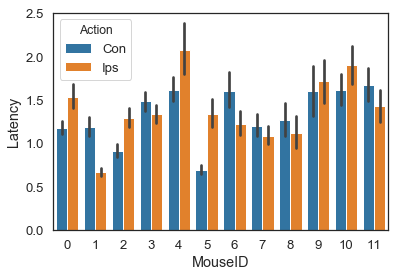

In [11]:
sns.barplot(x = 'MouseID', y = 'Latency', hue = 'Action', data = df_DMS)

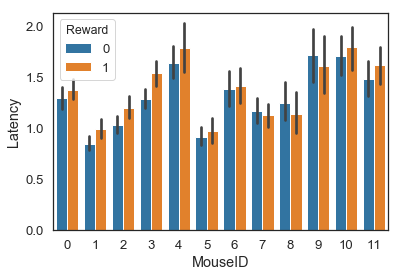

In [12]:
sns.barplot(x = 'MouseID', y = 'Latency', hue = 'Reward', data = df_DMS)

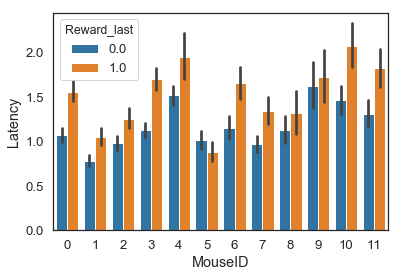

In [13]:
sns.barplot(x = 'MouseID', y = 'Latency', hue = 'Reward_last', data = df_DMS)

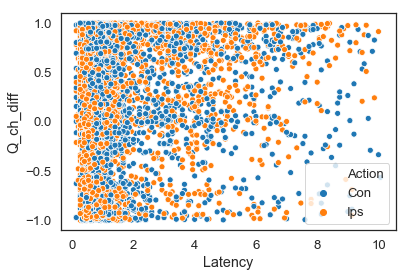

In [14]:

sns.scatterplot(x = 'Latency', y = 'Q_ch_diff', hue = 'Action', data = df_DMS)

In [15]:
v_cuts = pd.cut(df_DMS['Latency'], Q_BINS)
q_cuts = pd.qcut(df_DMS['Latency'], 3)

v_cuts.value_counts()

(0.123, 1.127]     7170
(1.127, 2.12]      1501
(3.113, 4.107]      429
(2.12, 3.113]       345
(4.107, 5.1]        258
(5.1, 6.093]        159
(6.093, 7.087]      110
(7.087, 8.08]        66
(8.08, 9.073]        45
(9.073, 10.067]      25
Name: Latency, dtype: int64

In [16]:
q_cuts.value_counts()

(0.132, 0.6]     3601
(0.6, 1.0]       3268
(1.0, 10.067]    3239
Name: Latency, dtype: int64

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


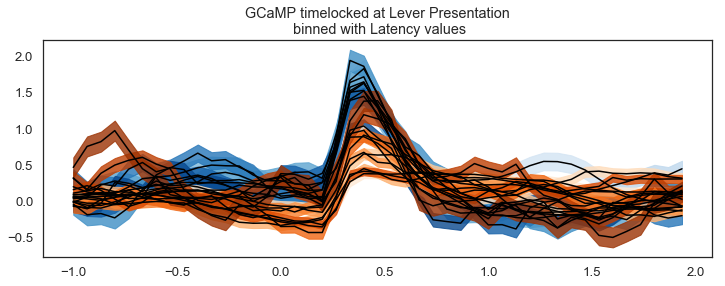

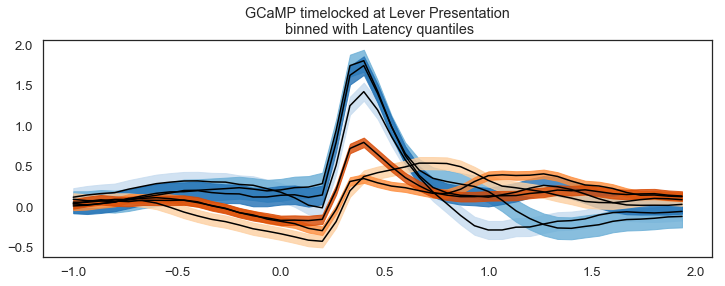

In [17]:

# constants: 
AVG_TIME_COURSE = np.arange(15, 30) # time course to average over. 15:30 corresponds to 0 to 1.0 seconds at timelock
Q_BINS = 10
Q_BINS_QUANTILES = Q_BINS






df_DMS['valuesLatency'] = pd.cut(df_DMS['Latency'], Q_BINS)


df_DMS['quantilesLatency'] = pd.qcut(df_DMS['Latency'], 3)




timelocked = 'g_lp'
tl_name = 'Lever Presentation'

categories = ['Con', 'Ips']
column = 'Action'





for bin_type in ['values', 'quantiles']:
    figure = plt.figure(figsize=(12, 4))
    for subcat, palette in zip(categories, ['Blues', 'Oranges']):
        df_src = df_DMS[df_DMS[column] == subcat]


        qlims = np.unique(df_src[bin_type + 'Latency'].dropna())
        for q_i, col in zip(qlims, sns.color_palette(palette, len(qlims))):
            x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
            y = np.mean(df_src[(df_src['Latency'] > q_i.left) & (df_src['Latency'] <= q_i.right)][timelocked], 0)
            error = np.std(y, axis = 0) / np.sqrt(NS)

            plt.plot(x, y, 'k')

            plt.fill_between(x, y-error, y+error, color = col, alpha = 0.8,  label = q_i)
            plt.title('GCaMP timelocked at ' + tl_name + '\n binned with Latency ' + bin_type)
    #     plt.legend(title = 'Q_Contra - Q_Ipsi of Last Trial', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)




In [18]:
for var in ['Latency']:
    for subcat, palette in zip(categories, ['Blues', 'Oranges']):
        figure = plt.figure(figsize=(12, 4))

        df_src = df_DMS[df_DMS[column] == subcat]


        qlims = np.unique(df_src['b' + var].dropna())
        for q_i, col in zip(qlims, sns.color_palette(palette, len(qlims))):
            x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
            y = np.mean(df_src[(df_src[var] > q_i.left) & (df_src[var] <= q_i.right)][timelocked], 0)
            error = np.std(y, axis = 0) / np.sqrt(NS)

            plt.plot(x, y, 'k')

            plt.fill_between(x, y-error, y+error, color = col, alpha = 0.8,  label = q_i)
            plt.title('GCaMP timelocked at ' + tl_name + '\n binned by ' + var)
    #     plt.legend(title = 'Q_Contra - Q_Ipsi of Last Trial', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


KeyError: 'bLatency'

<Figure size 864x288 with 0 Axes>

# checking quantiles

In [9]:

value_cuts = pd.cut(df_DMS['Q_ch_diff'], Q_BINS)
q_cuts = pd.qcut(df_DMS['Q_ch_diff'], Q_BINS)
value_cuts.value_counts()
q_cuts.value_counts()

(0.945, 1.0]         1011
(0.848, 0.945]       1011
(0.714, 0.848]       1011
(0.28, 0.534]        1011
(0.127, 0.28]        1011
(-0.128, 0.00106]    1011
(-0.633, -0.128]     1011
(-1.001, -0.633]     1011
(0.534, 0.714]       1010
(0.00106, 0.127]     1010
Name: Q_ch_diff, dtype: int64

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


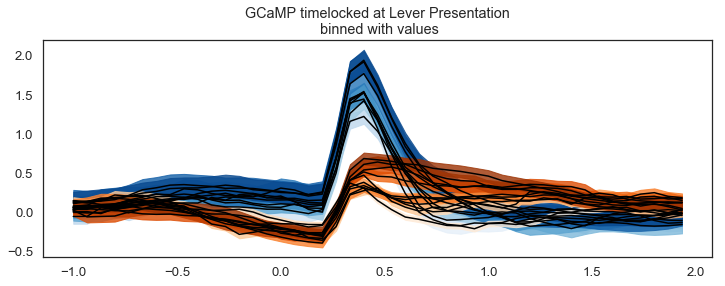

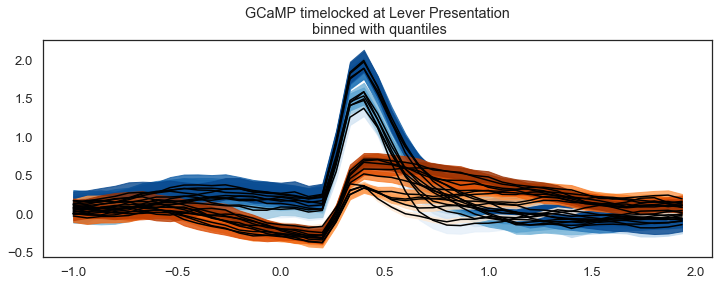

In [10]:

# constants: 





df_DMS['valuesQ_ch_diff'] = pd.cut(df_DMS['Q_ch_diff'], Q_BINS)

df_DMS['quantilesQ_ch_diff'] = pd.qcut(df_DMS['Q_ch_diff'], Q_BINS)






timelocked = 'g_lp'
tl_name = 'Lever Presentation'

categories = ['Con', 'Ips']
column = 'Action'




for bin_type in ['values', 'quantiles']:
    figure = plt.figure(figsize=(12, 4))
    for subcat, palette in zip(categories, ['Blues', 'Oranges']):
        df_src = df_DMS[df_DMS[column] == subcat]


        qlims = np.unique(df_src[bin_type + 'Q_ch_diff'].dropna())
        for q_i, col in zip(qlims, sns.color_palette(palette, len(qlims))):
            x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
            y = np.mean(df_src[(df_src['Q_ch_diff'] > q_i.left) & (df_src['Q_ch_diff'] <= q_i.right)][timelocked], 0)
            error = np.std(y, axis = 0) / np.sqrt(NS)

            plt.plot(x, y, 'k')

            plt.fill_between(x, y-error, y+error, color = col, alpha = 0.8,  label = q_i)
            plt.title('GCaMP timelocked at ' + tl_name + '\n binned with ' + bin_type)
    #     plt.legend(title = 'Q_Contra - Q_Ipsi of Last Trial', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

